# __Clustering 2__


Learning Objectives:
- Apply GMM and various density-based methods to different data sets and interpret the outputs
- Interpret the results to learn about the data structure
- Explore differences based on changing clustering parameters
- Visualise the clustering results

### Imports and Dataset

In [4]:
# IMPORTS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, MDS
from sklearn import metrics
import umap
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
import seaborn as sns

In [5]:
# read in the dataset

covid19_proteomics = pd.read_excel('../Data/COVID19_proteomics.xlsx')

# Scale the data with standard scaling (0 mean and unit variance)
covid19_proteomics_scaled = StandardScaler().fit_transform(covid19_proteomics.iloc[:, 3:])

# Create a dataframe with adenoma/carcinoma status and the scaled data
scaled_df = pd.DataFrame(covid19_proteomics_scaled)
scaled_df['COVID19'] = covid19_proteomics.COVID19

## Gaussian Mixture Models (GMM)

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. Read more [here](https://scikit-learn.org/stable/modules/mixture.html).

We will use the [`sklearn.mixture.GaussianMixture()`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) object to fit the model. Similar to dimensionality reduction and other clustering methods, one of the parameters to set for GMM models is the `n_components` (number of components). Another parameter is the `covariance_type` which can be one of the following options: 
- ‘full’: each component has its own general covariance matrix
- ‘tied’: all components share the same general covariance matrix
- ‘diag’: each component has its own diagonal covariance matrix
- ‘spherical’: each component has its own single variance

Here we will fit a GMM model and explore through visualisations how 

In [6]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:,:-1], scaled_df.COVID19, test_size=0.2, random_state=8)

<AxesSubplot:xlabel='0', ylabel='1'>

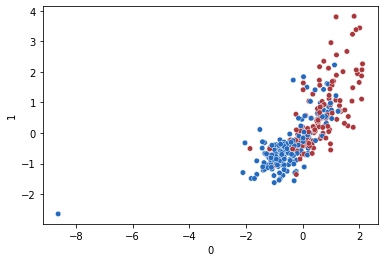

In [7]:
# fit a Gaussian Mixture Model with two components
gmm = GaussianMixture(n_components=2, covariance_type="full")
y_pred = gmm.fit_predict(X_train)

# here we take the first 2 proteomic features for the x and y axis 
sns.scatterplot(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_pred, s=30, cmap='vlag')


We can use PCA or another dimensionality reduction method (see previous tutorials on Dimensionality Reduction) to create components that encopass information from all our variables, and not just 2 random variables we select for visualisation. 

After we visualise the PCA results with the current GMM model, we will explore the different covariance options and how (or if) they change our clusters.


<AxesSubplot:>

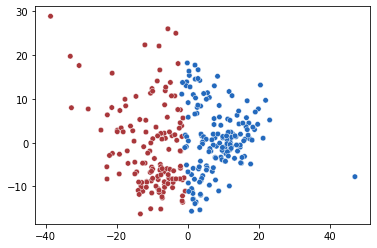

In [8]:
pca = PCA(n_components=2)
pca_df = pca.fit_transform(X_train)
sns.scatterplot(pca_df[:, 0], pca_df[:, 1], c=y_pred, s=30, cmap='vlag')

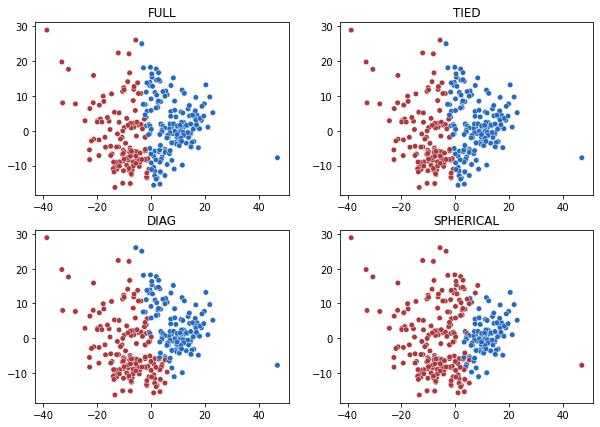

In [9]:
# function for fitting GMM models with the 4 different covariance options
def test_gmm_covariance (cov):
    gmm = GaussianMixture(n_components=2, covariance_type=cov)
    y_pred = gmm.fit_predict(X_train)
    pca = PCA(n_components=2)
    pca_df = pca.fit_transform(X_train)
    return pca_df, y_pred

cov_list = ['full', 'tied', 'diag', 'spherical']

# creating subplots 
plt.figure(figsize=(10,7))
for n, cov_type in enumerate(cov_list):
    ax = plt.subplot(2, 2, n+1)
    sns.scatterplot(test_gmm_covariance(cov_type)[0][:, 0], test_gmm_covariance(cov_type)[0][:, 1], 
                    c=test_gmm_covariance(cov_type)[1], s=30, cmap='vlag', ax=ax)
    ax.set_title(cov_type.upper())
    ax.set_xlabel("")
    

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN is a density-based clustering non-parametric algorithm. Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). Original paper found [here](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220).

We will use the [`sklearn.cluster.DBSCAN()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) object to fit our model. Below are some of the parameters that will need to be set, you will notice they are similar to other clustering techniques (i.e. k-means): 

- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
- `min_samples`: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
- `metric`: The metric to use when calculating distance between instances in a feature array.

Before fitting our DBSCAN model we will examine the best values for epsilon by using the `NearestNeighbours` function. After plotting the ditances we get, we will 
find the optimal value for epsilon at the point of maximum curvature:

<AxesSubplot:>

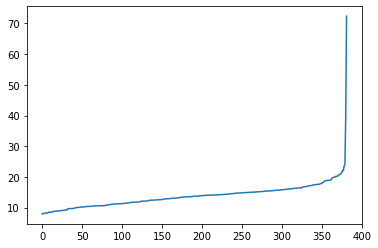

In [10]:
NN = NearestNeighbors(n_neighbors=2)
nbrs = NN.fit(scaled_df.iloc[:, :-1])
distances, indices = nbrs.kneighbors(scaled_df.iloc[:, :-1])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
# plt.plot(distances)
sns.lineplot(data=distances)

In [11]:
dbscan = DBSCAN(
    eps=19, 
    min_samples=3, 
    metric='euclidean'
).fit(scaled_df.iloc[:, :-1])

labels = dbscan.labels_
n_clusters_ = len(set(labels))
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(scaled_df.iloc[:, -1], labels))
print("Completeness: %0.3f" % metrics.completeness_score(scaled_df.iloc[:, -1], labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(scaled_df.iloc[:, :-1], labels))

Estimated number of clusters: 2
Estimated number of noise points: 66
Homogeneity: 0.049
Completeness: 0.068
Silhouette Coefficient: 0.172


<AxesSubplot:>

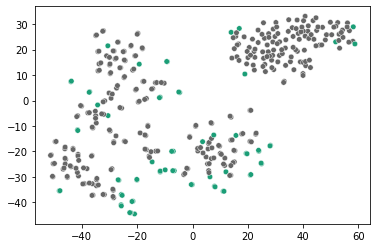

In [12]:
tsne_df = TSNE(
    n_components=2, 
    perplexity=10,
).fit_transform(scaled_df.iloc[:, :-1])
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], c=labels, s=30, cmap='Dark2')

As you can see the clusters found by DBSCAN don't really correspond to the TSNE visualisations, try reducing the dimensions of the dataset with PCA and see if your results are more informative. Make sure to also tweak the parameters of the DBSCAN model to check how sensitive it is to even small changes! You can also rerun the GMM models with TSNE or kernel-TSNE decompositions and look at how the visualisations change. Feel free to utilise the code in the cell below to do a side-to-side comparison of the parameter you are changing. The example below still uses TSNE as the dimensionality reduction method, make sure whichever method you pick that you set a `random_state` parameter, so that the embeddings are the same across all iterations. 

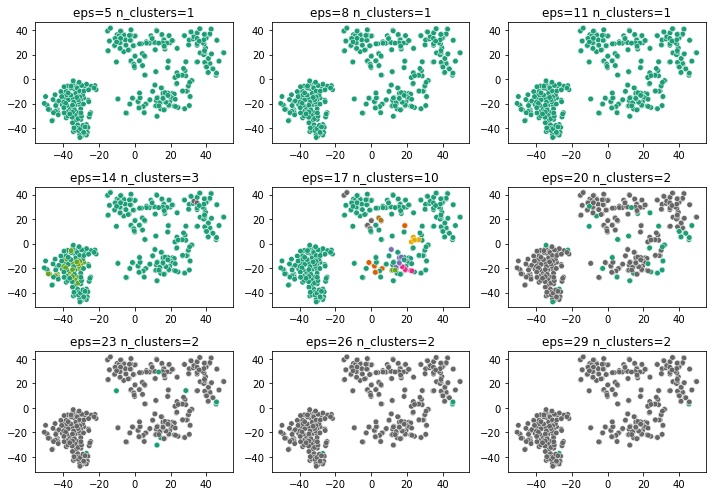

In [41]:
def test_dbscan(eps):
    dbscan = DBSCAN(
    eps=eps, 
    min_samples=3, 
    metric='euclidean', 
).fit(scaled_df.iloc[:, :-1])
    
    tsne_df = TSNE(
    n_components=2, 
    perplexity=10,
    random_state=10,
).fit_transform(scaled_df.iloc[:, :-1])
    
    labels = dbscan.labels_
    return tsne_df, labels

eps_values = np.arange(5, 30, 3)

# creating subplots 
plt.figure(figsize=(10,7))
for n, eps in enumerate(eps_values):
    ax = plt.subplot(3, 3, n+1)
    sns.scatterplot(test_dbscan(eps)[0][:, 0], test_dbscan(eps)[0][:, 1], 
                    c=test_dbscan(eps)[1], s=30, cmap='Dark2', ax=ax)
    ax.set_title('eps='+str(eps)+' n_clusters='+str(len(set(test_dbscan(eps)[1]))))
    ax.set_xlabel("")
plt.tight_layout()

## Ordering Points To Identify the Clustering Structure (OPTICS)

OPTICS, closely related to DBSCAN, finds core sample of high density and expands clusters from them.  Unlike DBSCAN, keeps cluster hierarchy for a variable neighborhood radius. Better suited for usage on large datasets than the current sklearn implementation of DBSCAN. Clusters are then extracted using a DBSCAN-like method (cluster_method = ‘dbscan’) or an automatic technique (cluster_method = ‘xi’). This implementation deviates from the original OPTICS by first performing k-nearest-neighborhood searches on all points to identify core sizes, then computing only the distances to unprocessed points when constructing the cluster order. Note that we do not employ a heap to manage the expansion candidates, so the time complexity will be O(n^2). The original methodology paper can be found [here](https://dl.acm.org/doi/10.1145/304181.304187). Belwo are some parameters we will be changing today: 

- `min_samples`: The number of samples in a neighborhood for a point to be considered as a core point.
- `max_eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other. Default value of `np.inf` will identify clusters across all scales; reducing `max_eps` will result in shorter run times.
- `metric`: Metric to use for distance computation, default here is '_minkowski_' as oppoed to euclidean in DBSCAN.
- `p`: Parameter for the Minkowski metric from pairwise_distances. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.



In [13]:
optics = OPTICS(
    min_samples=3, 
    max_eps=np.inf,
    p=4
).fit(scaled_df.iloc[:, :-1])

labels = optics.labels_
n_clusters_ = len(set(labels))
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(scaled_df.iloc[:, -1], labels))
print("Completeness: %0.3f" % metrics.completeness_score(scaled_df.iloc[:, -1], labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(scaled_df.iloc[:, :-1], labels))

Estimated number of clusters: 4
Estimated number of noise points: 371
Homogeneity: 0.027
Completeness: 0.105
Silhouette Coefficient: -0.198


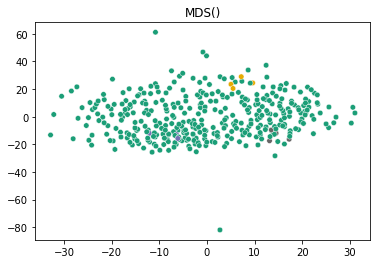

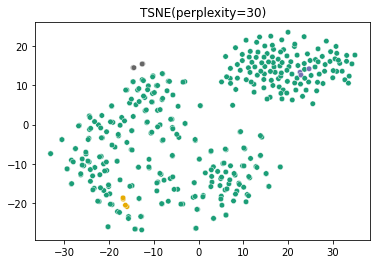

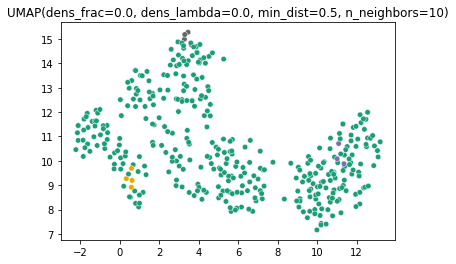

In [15]:
def dim_reduction(method):
    df = method.fit_transform(scaled_df.iloc[:, :-1])
    sns.scatterplot(df[:, 0], df[:, 1], c=labels, s=30, cmap='Dark2')
    plt.title(method)
    plt.show()

dim_reduction(MDS(n_components=2, metric=True))
dim_reduction(TSNE(n_components=2, perplexity=30))
dim_reduction(umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.5))